In [1]:
%load_ext autoreload
%autoreload 2
import comp_capacity

import comp_capacity.repr
import comp_capacity.repr.network

In [381]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/Users/richardhakim/Documents/github_repos/computational-capacity/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_nodes = 10

module_dict = {
    "linear": torch.nn.Linear,
}

nonlinearity_dict = {
    "relu": torch.nn.ReLU,
    "sigmoid": torch.nn.Sigmoid,
    "tanh": torch.nn.Tanh,
}

In [4]:
n_modules = len(module_dict)
n_nonlinearities = len(nonlinearity_dict)

module_namesIndex = {name: ii for ii, name in enumerate(module_dict.keys())}
nonlinearity_namesIndex = {name: ii for ii, name in enumerate(nonlinearity_dict.keys())}

In [5]:
print(module_namesIndex)
print(nonlinearity_namesIndex)

{'linear': 0}
{'relu': 0, 'sigmoid': 1, 'tanh': 2}


In [6]:
connectivity = (torch.rand(size=(n_nodes, n_nodes), dtype=torch.float32) * 2 - 1).triu(diagonal=1)
module = torch.ones(size=(n_nodes, n_modules), dtype=torch.bool) * torch.as_tensor([1, 0], dtype=torch.bool)[None, :]
nonlinearity = torch.ones(size=(n_nodes, n_nonlinearities), dtype=torch.bool) * torch.as_tensor([1, 0, 0], dtype=torch.bool)[None, :]

network = comp_capacity.repr.network.Network(
    matrices=comp_capacity.repr.network.MatrixContainer(
        connectivity=connectivity,
        module=module,
        nonlinearity=nonlinearity,
    )
)

In [7]:
network

Network. Constructor matrices: MatrixContainer: 
  Connectivity -- shape: torch.Size([10, 10]), dtype: torch.float32, device: cpu, requires_grad: False; 
  Module       -- shape: torch.Size([10, 2]), dtype: torch.bool, device: cpu, requires_grad: False; 
  Nonlinearity -- shape: torch.Size([10, 3]), dtype: torch.bool, device: cpu, requires_grad: False; 

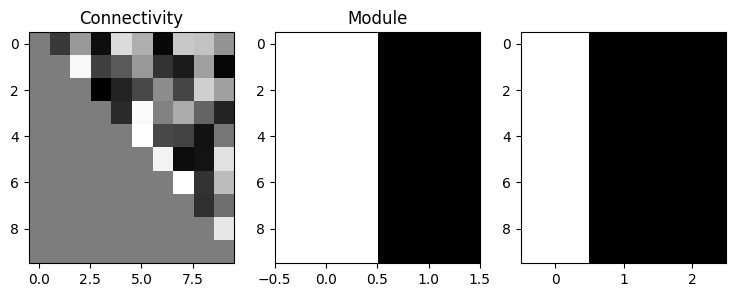

In [8]:
network.plot_matrices()

In [9]:
connectivity_constraint = torch.ones(size=(n_nodes, n_nodes), dtype=torch.bool).triu(diagonal=1)
module_constraint = torch.ones(size=(n_nodes, n_modules), dtype=torch.bool) * torch.as_tensor([1, 0], dtype=torch.bool)[None, :]
nonlinearity_constraint = torch.ones(size=(n_nodes, n_nonlinearities), dtype=torch.bool) * torch.as_tensor([1, 0, 0], dtype=torch.bool)[None, :]
connectivity_bounds = (-1.0, 1.0)
module_bounds = (1, 1)
nonlinearity_bounds = (1, 1)

sampler = comp_capacity.repr.network.Sampler_random(
    connectivity_constraint=connectivity_constraint,
    module_constraint=module_constraint,
    nonlinearity_constraint=nonlinearity_constraint,
    
    connectivity_bounds=connectivity_bounds,
    module_bounds=module_bounds,
    nonlinearity_bounds=nonlinearity_bounds,
    
    dtype_connectivity=torch.float32,
    dtype_module=torch.bool,
    dtype_nonlinearity=torch.bool,
)

In [10]:
network = sampler.forward(network=network)

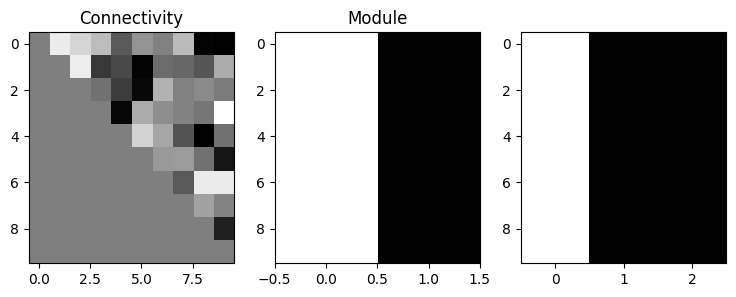

In [11]:
network.plot_matrices()

demo for feedforward network

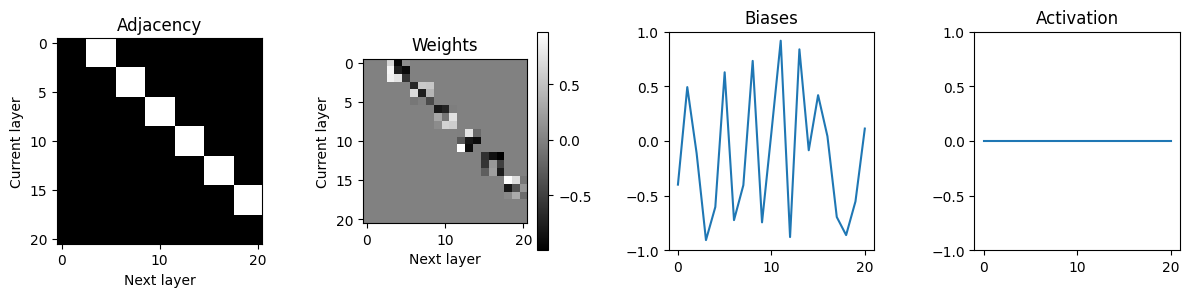

In [330]:
sizes_layers = [
    3,
    3,
    3,
    3,
    3,
    3,
    3,
]

n_nodes = sum(sizes_layers)
n_layers = len(sizes_layers)

adjacency = torch.zeros(size=(n_nodes, n_nodes), dtype=torch.float32)

for i_layer in range(n_layers - 1):
    idx_layer = slice(sum(sizes_layers[:i_layer]), sum(sizes_layers[:i_layer + 1]))
    idx_next_layer = slice(sum(sizes_layers[:i_layer + 1]), sum(sizes_layers[:i_layer + 2]))
    adjacency[idx_layer, idx_next_layer] = True
    
weights = torch.empty(size=(n_nodes, n_nodes), dtype=torch.float32).uniform_(-1, 1) * adjacency
biases = torch.empty(size=(n_nodes,), dtype=torch.float32).uniform_(-1, 1)
act = torch.zeros(size=(n_nodes,), dtype=torch.float32)
# act[:, 0] = torch.empty(size=(n_nodes,), dtype=torch.float32).uniform_(-1, 1)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(adjacency, cmap="gray")
axs[0].set_title("Adjacency")
axs[0].set_xlabel("Next layer")
axs[0].set_ylabel("Current layer")

axs[1].imshow(weights, cmap="gray", clim=(min(weights.min(), -1), max(weights.max(), 1)))
axs[1].set_title("Weights")
axs[1].set_xlabel("Next layer")
axs[1].set_ylabel("Current layer")

axs[2].plot(biases)
axs[2].set_ylim(min(biases.min(), -1), max(biases.max(), 1))
axs[2].set_title("Biases")

axs[3].plot(act)
axs[3].set_ylim(min(act.min(), -1), max(act.max(), 1))
axs[3].set_title("Activation")

## Make colorbars
fig.colorbar(axs[1].imshow(weights, cmap="gray"), ax=axs[1])
plt.tight_layout()

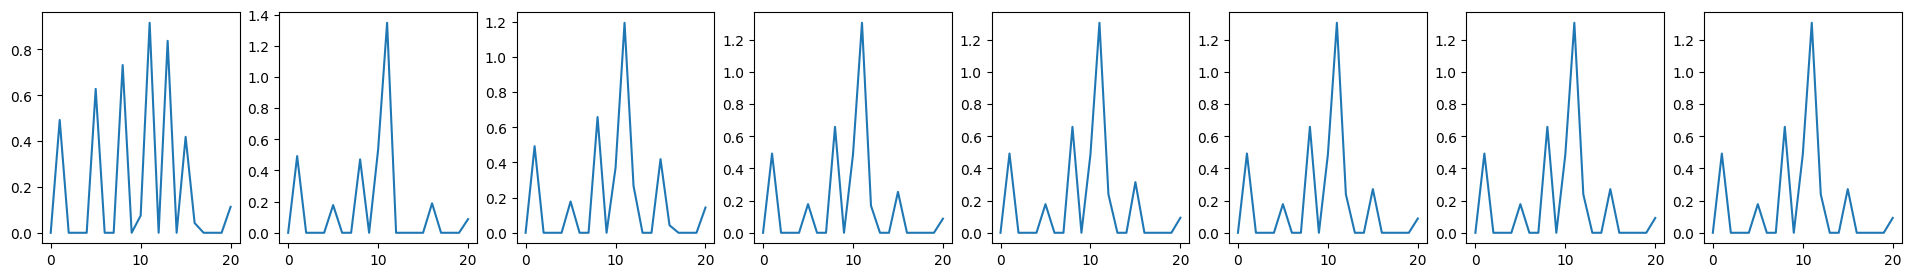

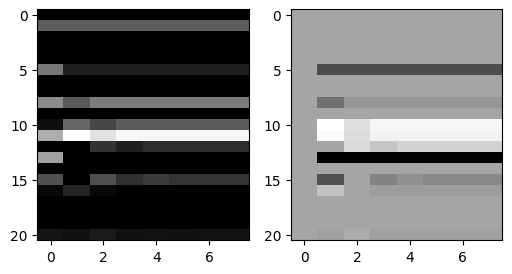

In [331]:
## Recursively activate the network a few times to reach a steady state
n_iterations = n_layers + 1

outputs = torch.zeros(size=(n_nodes, n_iterations), dtype=torch.float32)
fig, axs = plt.subplots(1, n_iterations, figsize=(3 * n_iterations, 3))
for i in range(n_iterations):
    act = torch.nn.functional.relu(act @ weights + biases)
    # act = act @ weights + biases
    outputs[:, i] = act
    axs[i].plot(act)
    
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(outputs, cmap="gray", aspect='auto')
axs[1].imshow(outputs - torch.nn.functional.relu(biases[:, None]), cmap="gray", aspect='auto')

In [332]:
## train on sklearn digits
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing

digits = sklearn.datasets.load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sklearn.preprocessing.StandardScaler().fit_transform(X_train)
X_test = sklearn.preprocessing.StandardScaler().fit_transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [346]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(96,), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.78%


Now let's make a network that does mimics an MLP

In [1028]:
class BlockOffDiagonalRNN(torch.nn.Module):
    """
    Recurrent block off-diagonal network that implements a multilayer perceptron
    via recursive weight application.
    RH 2025

    Args:
        input_size (int):
            Dimensionality of input features.
        hidden_sizes (List[int]):
            Sizes of each hidden layer.  For one hidden layer use [H,].
        output_size (int):
            Number of output units (e.g. classes).
        activation (callable):
            Nonlinearity to use between layers (default: relu).

    """
    def __init__(
        self,
        input_size: int,
        hidden_sizes: list[int],
        output_size: int,
        activation: callable = torch.nn.functional.relu,
    ):
        super().__init__()
        # store sizes
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation = activation

        # total number of nodes = input + hidden… + output
        self.n_nodes = input_size + sum(hidden_sizes) + output_size
        # one transition per layer (input→H1, H1→H2, …, H_last→output)
        self.n_steps = len(hidden_sizes) + 1

        # build index slices
        idx = 0
        self.input_slice = slice(idx, idx + input_size)
        idx += input_size

        self.hidden_slices = []
        for h in hidden_sizes:
            s = slice(idx, idx + h)
            self.hidden_slices.append(s)
            idx += h

        self.output_slice = slice(idx, idx + output_size)

        # create the mask (connections only i→i+1 blocks)
        mask = torch.zeros(self.n_nodes, self.n_nodes, dtype=torch.float32)
        # input → first hidden
        mask[self.input_slice, self.hidden_slices[0]] = 1.0
        # hidden→hidden (if more than one hidden layer)
        for prev_h, next_h in zip(self.hidden_slices, self.hidden_slices[1:]):
            mask[prev_h, next_h] = 1.0
        # last hidden → output
        mask[self.hidden_slices[-1], self.output_slice] = 1.0
        self.register_buffer("mask", mask)

        # parameters: full weight matrix + bias for every node
        self.weight = torch.nn.Parameter(torch.empty(self.n_nodes, self.n_nodes))
        self.bias = torch.nn.Parameter(torch.zeros(self.n_nodes,))

        # zero out biases on input units (they stay fixed)
        bias_mask = torch.ones(self.n_nodes, dtype=torch.float32)
        bias_mask[self.input_slice] = 0.0
        self.register_buffer("bias_mask", bias_mask)

        # initialize
        torch.nn.init.xavier_uniform_(self.weight)
        # enforce zeros where mask=0 (so unused connections stay zero)
        with torch.no_grad():
            self.weight.mul_(self.mask)

    def _recurse(
        self,
        state: torch.Tensor,
        original_input: torch.Tensor,
        steps_remaining: int
    ) -> torch.Tensor:
        """
        Recursive application of W + bias + nonlinearity.

        Args:
            state (Tensor[B, n_total]):
                Current full-state (input + hidden + output slots).
            original_input (Tensor[B, input_size]):
                The fixed input to reinject each step.
            steps_remaining (int):
                How many transitions to apply before returning.

        Returns:
            Tensor[B, n_total]: Updated state after all steps.
        """
        if steps_remaining == 0:
            return state

        # linear update: only block off‐diagonal rows are nonzero
        W_masked = self.weight * self.mask
        b_masked = self.bias * self.bias_mask
        # W_masked = self.weight
        # b_masked = self.bias
        updated = state @ W_masked + b_masked  # (B, n_total)

        # nonlinearity on all but the final (so output layer is linear logits)
        if steps_remaining > 1:
            updated = self.activation(updated)

        # rebuild new state: re‑inject input in front, keep rest from updated
        new_state = torch.cat([original_input, updated[:, self.input_size:]], dim=1)

        return self._recurse(state=new_state, original_input=original_input, steps_remaining=steps_remaining - 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (Tensor[B, input_size]): Input batch.

        Returns:
            Tensor[B, output_size]: Logits for each class.
        """
        batch_size = x.size(0)
        # initialize full state with zeros, then put x in the input slots
        state = x.new_zeros((batch_size, self.n_nodes))
        state[:, self.input_slice] = x

        final_state = self._recurse(state=state, original_input=x, steps_remaining=self.n_steps)
        # return only the output slots
        return final_state[:, self.output_slice]

In [1030]:
# --- Now train on sklearn's digits dataset ---
device = torch.device("cpu")

# load and split
digits = sklearn.datasets.load_digits()
X = torch.tensor(digits.data, dtype=torch.float32)
y = torch.tensor(digits.target, dtype=torch.long)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

train_ds = torch.utils.data.TensorDataset(X_train, y_train)
test_ds = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
)

# instantiate model
model = BlockOffDiagonalRNN(
    input_size=64,
    hidden_sizes=[64],      # one hidden layer of 64 units; change as desired
    output_size=10,
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# training loop
n_epochs = 200
for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss += 0.001 * torch.sum(model.weight ** 2)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    avg_loss = running_loss / len(train_loader.dataset)

    # evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_X.size(0)

    acc = correct / total * 100
    print(f"Epoch {epoch:2d}/{n_epochs}, Loss: {avg_loss:.4f}, Test Acc: {acc:.2f}%")

Epoch  1/200, Loss: 1.4311, Test Acc: 82.50%
Epoch  2/200, Loss: 0.4406, Test Acc: 92.50%
Epoch  3/200, Loss: 0.2684, Test Acc: 94.72%
Epoch  4/200, Loss: 0.2125, Test Acc: 95.83%
Epoch  5/200, Loss: 0.1706, Test Acc: 96.11%
Epoch  6/200, Loss: 0.1436, Test Acc: 96.11%
Epoch  7/200, Loss: 0.1235, Test Acc: 96.67%
Epoch  8/200, Loss: 0.1085, Test Acc: 97.22%
Epoch  9/200, Loss: 0.1028, Test Acc: 97.22%
Epoch 10/200, Loss: 0.0896, Test Acc: 97.22%
Epoch 11/200, Loss: 0.0804, Test Acc: 96.94%
Epoch 12/200, Loss: 0.0748, Test Acc: 97.50%
Epoch 13/200, Loss: 0.0714, Test Acc: 97.50%
Epoch 14/200, Loss: 0.0661, Test Acc: 97.22%
Epoch 15/200, Loss: 0.0624, Test Acc: 97.78%
Epoch 16/200, Loss: 0.0595, Test Acc: 97.50%
Epoch 17/200, Loss: 0.0566, Test Acc: 98.06%
Epoch 18/200, Loss: 0.0539, Test Acc: 96.94%
Epoch 19/200, Loss: 0.0528, Test Acc: 97.78%
Epoch 20/200, Loss: 0.0496, Test Acc: 97.22%
Epoch 21/200, Loss: 0.0489, Test Acc: 97.22%
Epoch 22/200, Loss: 0.0471, Test Acc: 97.22%
Epoch 23/2

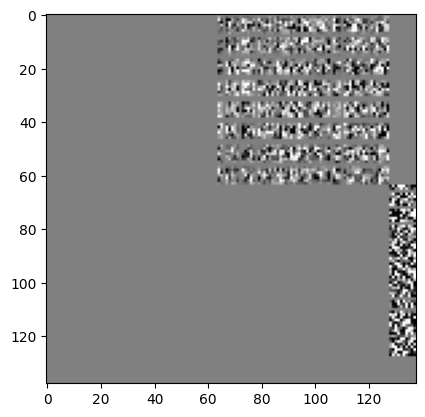

In [1032]:
plt.figure()
plt.imshow(dict(model.named_parameters())['weight'].detach().cpu(), cmap="gray", clim=(-.1, .1))